In [57]:
#imports
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns
from brainglobe_atlasapi.bg_atlas import BrainGlobeAtlas
from brainrender import Scene
from brainrender.actors import Neuron
import vedo
import time
import scanpy as sc
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import json

In [58]:
#import allen atlas
ccf_v3_10um = BrainGlobeAtlas('allen_mouse_10um')

In [59]:
#function definitions
def drop_by_thresh(df, thresh):
    '''
    this is written to drop columns of a data frame that have a sum value of below the input threshold
    df: pandas.DataFrame
    thresh: float
    returns: pandas.DataFrame
    '''
    sum_df = df.apply(np.sum, axis=0)
    mask = sum_df < thresh
    low_endpoint_regions = sum_df[mask].index
    return df.drop(low_endpoint_regions, axis=1)

def load_data_from_dir(direct):
    '''
    load data from a directory into a pandas DataFrame, replaces NaNs with 0s for the purpose of this notebook
    functional for .csv files containing endpoint frequency
    dir: string
    returns: pandas.DataFram
    '''
    data = pd.DataFrame()
    print('Loading files:')
    for file in tqdm(os.listdir(direct)):
        filename = os.path.join(direct, file)
        df = pd.read_csv(filename, header=None)
        df[0] = df[0] + df[1]
        df[1] = df[2]
        del df[2]
        df = df.loc[(df!=0).any(axis=1)]
        df_t = df.transpose()
        file = file.replace('_freq.csv','')
        file = file.replace('_length.csv', '')
        df_t = df_t.rename(index={1: file})
        df_t.columns = df_t.iloc[0]
        df_t = df_t.drop([0])
        data = pd.concat([data, df_t], join='outer')
    data_nonan = data.replace(np.nan, 0)
    return data_nonan

def preprocess(df):
    '''
    preprocess data however I want to, accepts a pandas.DataFrame with no NaNs
    df: pandas.DataFrame
    returns: pandas.DataFrame
    '''
    #remove zero variance columns
    selector = VarianceThreshold(threshold=0.0).set_output(transform='pandas')
    df = selector.fit_transform(df)
    
    # data_toln = data_thresh.copy()
    data_tonorm = df.copy()

    #natural log scale my data, formula of ln(number of terminals + 1) as per Ding et al. 2025
    #and control for cell size
    row_sums = data_tonorm.sum(axis=1)
    df_pct = (data_tonorm.div(row_sums, axis=0))*100
    df_log = np.log(df_pct+1)

    return df_log

def cluster_and_plot(df, row_colors=None, **plot_info):
    '''
    hierarchically cluster and plot data using seaborn.clustermap using euclidean distance with ward's linkage
    df: pandas.DataFramea

    plot_info: matplotlib kwargs
    returns: None
    '''
    #don't think im actually using this atm
    cmap = sns.clustermap(df, 
                  method='ward', 
                  metric='euclidean', 
                  row_cluster=False,
                  dendrogram_ratio=(.1, .15),
                  cbar_pos=(0, .15, .03, .7),
                  cbar_kws={'label': 'ln(terminals in region + 1)'},
                  yticklabels=True,
                  xticklabels=True,
                  row_colors=row_colors)
    
    return cmap

def merge_region_counts(list1, list2):
    # thanks deepseek
    # Create a dictionary to aggregate counts
    region_counts = {}
    
    # Process first list
    for region, count in list1:
        region_counts[region] = region_counts.get(region, 0) + count
    
    # Process second list
    for region, count in list2:
        region_counts[region] = region_counts.get(region, 0) + count
    
    # Convert back to list of tuples
    merged_list = [(region, count) for region, count in region_counts.items()]
    
    return merged_list

def json_to_freq_from_dir(dir):
    #this works for all recons that i got from allen online viewer, but ones i had beforehand seem to have slightly different json structure
    #wouldn't be difficult to rewrite functionality for that as well however
    data = pd.DataFrame()

    for file in tqdm(os.listdir(dir)):
        filename = os.path.join(dir, file)
        with open(filename,'r') as f:
            file_dict = json.load(f)

        #setting z vals for lateralization info
        somaz = file_dict['neurons'][0]['soma']['z']
        #midline est very approximate, no exact way to determine this
        #maybe theres a better way to figure out lateralization but i'm not sure atm
        midlinez = 5750
        somaref = midlinez-somaz
        somasign = np.sign(somaref)

        endpoints = []

        #search for all endpoints (structureIdentifier == 6)
        for node in file_dict['neurons'][0]['axon']:
            if node['structureIdentifier'] == 6:
                endpoints.append(node)

        freq_dict = {}

        for node in endpoints:
            region = node['allenId']
            z = node['z']
            zref = midlinez-z
            zsign = np.sign(zref)
            ipsstr = 'Ipsilateral ' + ccf_v3_10um.structures[region]['acronym']
            constr = 'Contralateral ' + ccf_v3_10um.structures[region]['acronym']
            #ipsilateral condition
            if zsign == somasign:
                if ipsstr in freq_dict:
                    freq_dict[ipsstr] += 1
                else:
                    freq_dict[ipsstr] = 1
            #contralat condition
            if zsign != somasign:
                if constr in freq_dict:
                    freq_dict[constr] += 1
                else:
                    freq_dict[constr] = 1
        #print(freq_dict)

        ser = pd.Series(freq_dict, name=file_dict['neurons'][0]['idString'])
        #print(ser)
        #this join might be an issue, it seems to be adding duplicate regions so that each neuron has its own column for each region it projects to...
        data = pd.concat([data, ser], join='outer', axis=1)
        data_nonan = data.replace(np.nan, 0)
        datat = data_nonan.T

    return datat

In [39]:
ccf_v3_10um.structures["CB"]["structure_id_path"]

[997, 8, 512]

In [7]:
#have to change swc coords so this renders correctly, swap x and y around i think?
#will do another time though, not in a rush since i can render in SNT
vedo.settings.default_backend='vtk'
ccf_scene = Scene(atlas_name='allen_mouse_10um')
N032_674185 = Neuron(neuron=r'C:\Users\samkr\OneDrive\Documents\BU\AllenExASPIM\medulla_IRN_PRN_PGRN\json_swc\swc\N032-674185-IB.swc')
ccf_scene.add(N032_674185)
ccf_scene.render(camera='frontal') 

KeyboardInterrupt: 

In [60]:
#data input
#on my PC in lab dir is C:\Users\samkr\OneDrive\Documents\Code\reconstructions\SNT_histos\SNT_histos\frequency
#on shared PC its ...
frequency_dir = input('Input directory with region frequency data: ') #C:\Users\samkr\OneDrive\Documents\Code\reconstructions\SNT_histos\SNT_histos\frequency
json_dir = input('Input directory with new reconstruction json files: ') #C:\Users\samkr\OneDrive\Documents\BU\AllenExASPIM\medulla_IRN_PRN_PGRN\json_w_names\new_recons
#length_dir = input('Input directory with region length data: ') #C:\Users\samkr\OneDrive\Documents\Code\reconstructions\SNT_histos\SNT_histos\length

In [61]:
#load frequency and length data in
frequency_data = load_data_from_dir(frequency_dir)
json_freq = json_to_freq_from_dir(json_dir)
#length_data = load_data_from_dir(length_dir)
#print("Column variances:", np.var(data, axis=0))

Loading files:


100%|██████████| 69/69 [00:04<00:00, 17.24it/s]
C:\Users\samkr\AppData\Local\Temp\ipykernel_48636\3888476880.py:37: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_nonan = data.replace(np.nan, 0)
100%|██████████| 49/49 [00:02<00:00, 18.97it/s]


In [68]:
print(len(json_freq.index))

49


In [ ]:
#okay so just notes on what to do next, i have to reannotate new regions so they sort correctly
full_freq = pd.concat([frequency_data, json_freq], axis=0)
full_freq = full_freq.replace(np.nan, 0)

        Ipsilateral IRN  Ipsilateral MDRN  Ipsilateral VII  Ipsilateral LIN  \
AA0434             29.0               8.0              5.0              3.0   
AA0503              8.0               8.0              0.0              0.0   
AA0947             24.0               7.0              0.0              0.0   
AA1196             55.0              20.0              0.0              0.0   
AA1313            161.0              50.0              0.0              6.0   

        Ipsilateral PARN  Ipsilateral MY  Ipsilateral GRN  Ipsilateral PGRN  \
AA0434               2.0             1.0              1.0               0.0   
AA0503               7.0            14.0             19.0              15.0   
AA0947              13.0             4.0              0.0               0.0   
AA1196              34.0            31.0              2.0               0.0   
AA1313             262.0            14.0              0.0               0.0   

        Ipsilateral V  Ipsilateral XII  ...  Contr

In [ ]:
# #dropping mossy fibers so they aren't included in subsequent analyses
# #i guess i don't need to do this, ill include for now but can use this cell if i want to drop
# mossy_list = ['N012-674185-PG', 'N123-708369-HS', 'N017-715345-YV', 'N024-715345-SA', 'N035-674191-FMR', 'N031-715345-DS', 'N041-674191-AR', 'N056-686955-JN', 'N057-686955-SA', 'N113-708369-JN',
#                'N114-708369-HS', 'N115-708369-BP', 'N016-715345-HD', 'N023-715346-PC', 'N037-674185-IB', 'N044-674191-SP']
# for cell in mossy_list:
#     #print(cell)
#     frequency_data = frequency_data.drop(cell)

# print(len(frequency_data.index)) #should be 53, 69 total and 16 mossy fibers

53


In [72]:
#remove 0 variance columns, think they arise over some SNT weirdness but not really sure
selector = VarianceThreshold(threshold=0.0).set_output(transform='pandas')
df_tosum = selector.fit_transform(full_freq)


In [73]:
df_summed = df_tosum.sum(axis=0)
print(type(df_tosum))
# mask = df_summed > 10
# df_summed = df_summed[mask]
#df_summed = np.sort(df_summed)

<class 'pandas.core.frame.DataFrame'>


In [74]:
#merge the same regions from different hemispheres
zipped_regions = zip(df_tosum.keys(), df_summed)
regions_c = []
regions_i = []
for region, value in zipped_regions:
    #print(region, value)
    expi = 'Ipsilateral'
    expc = 'Contralateral'
    if expi in region:
        reg = region.replace(expi+' ', '')
        regions_i.append((reg, value))
    if expc in region:
        reg2 = region.replace(expc+' ', '')
        regions_c.append((reg2, value))
# print(regions_i)
# print(regions_c)
#check to be sure i didn't lose regions when doing this (not very robust tho)
# for ii in regions_i:
#     ri, vi = ii
#     for ic in regions_c:
#         rc, vc = ic
#         if ri == rc:
#             print(f'{ri} in both hems')
#         continue
merged = merge_region_counts(regions_i, regions_c)
# print(len(merged_regions))
# print(merged_regions)
merged_regions = []
for i in merged:
    k, v = i
    if k == 'Other':
        continue
    else:
        merged_regions.append(i)
        

In [75]:
#get a summary bar plot of the most frequent regions that have significant projections, by percentage of total projections out of the whole dataset
sum = 0
for i in merged_regions:
    k, v = i
    sum += v
percentages = []
for i in merged_regions:
    k, v = i
    perc = (v/sum)*100
    percentages.append((k, perc))
sort_perc = sorted(percentages, key=lambda item: item[1])
sort_perc.reverse()
print(len(sort_perc))
perc_thresh = [(k, v) for k, v in sort_perc if v >= 1]
print(len(perc_thresh))
print(10/sum)
print(merged_regions)

280
25
0.00011460004584001834
[('IRN', 14032.0), ('MDRN', 1229.0), ('VII', 1559.0), ('LIN', 317.0), ('PARN', 7833.0), ('MY', 3423.0), ('GRN', 5045.0), ('PGRN', 103.0), ('V', 1761.0), ('XII', 2549.0), ('P', 2314.0), ('P5', 2754.0), ('PRNr', 404.0), ('MARN', 394.0), ('PCG', 95.0), ('LRN', 8.0), ('PHY', 37.0), ('LDT', 45.0), ('RO', 49.0), ('tspc', 173.0), ('PSV', 1654.0), ('VNC', 74.0), ('PB', 1082.0), ('PRNc', 1727.0), ('uf', 14.0), ('rust', 108.0), ('MTN', 26.0), ('SUT', 1360.0), ('MB', 659.0), ('ILM', 12.0), ('scp', 241.0), ('CB', 135.0), ('SLD', 31.0), ('SPVC', 1732.0), ('das', 12.0), ('MRN', 1119.0), ('RM', 93.0), ('TRN', 9.0), ('NTS', 1424.0), ('PPN', 216.0), ('x', 36.0), ('sptV', 105.0), ('PAG', 648.0), ('mlf', 48.0), ('Acs5', 196.0), ('SPVI', 1977.0), ('DMX', 369.0), ('SPVO', 1365.0), ('AMB', 1.0), ('sctv', 13.0), ('I5', 92.0), ('ACVII', 10.0), ('DCN', 3.0), ('SOC', 5.0), ('ISN', 11.0), ('Pa5', 10.0), ('PC5', 62.0), ('ll', 42.0), ('V4', 22.0), ('c', 2.0), ('VIIn', 55.0), ('pyd', 1


[
    Text(0.5, 1.0, 'Most frequently targeted regions from IRN/PARN'),
    Text(0.5, 0, 'Percentage out of total dataset'),
    Text(0, 0.5, 'region')
]

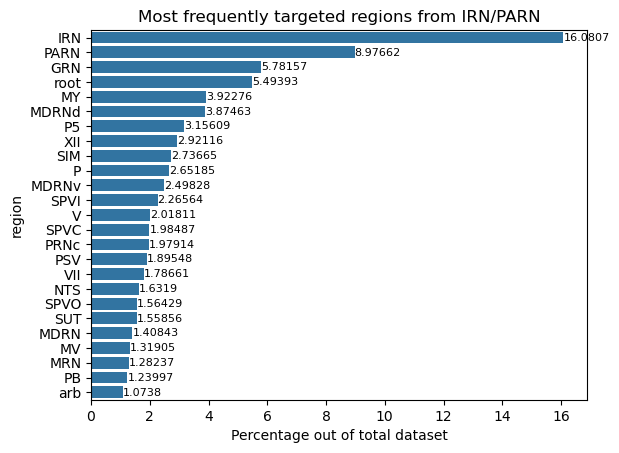

In [76]:
#exclude mossy fibers from this? i dont think its necessary 
x = [k for k, _ in perc_thresh]
y = [v for _, v in perc_thresh]
ax = sns.barplot(x=y, y=x)
ax.bar_label(ax.containers[0], fontsize=8)
ax.set(title='Most frequently targeted regions from IRN/PARN', xlabel='Percentage out of total dataset', ylabel='region')

In [ ]:
#merge ipsi/contra region frequency values, then preprocess
#this merges for each neuron, instead of summing and merging as done before, although it needs some rewriting
# for row in frequency_data.iterrows():
#     keys = []
#     values = []
#chat gpt code
ipsi_cols = [col for col in full_freq.columns if col.startswith('Ipsilateral')]
contra_cols = [col for col in full_freq.columns if col.startswith('Contralateral')]

# Strip hemisphere prefix to identify shared brain regions
ipsi_regions = [col.replace('Ipsilateral ', '') for col in ipsi_cols]
contra_regions = [col.replace('Contralateral ', '') for col in contra_cols]

# Find shared regions (in case some mismatch exists) (GPT)
#nope actually union of all regions, since there are some regions that only recieve ipsilateral projections
all_regions = set(ipsi_regions) | set(contra_regions)

# Build the new DataFrame
merged_frequency = pd.DataFrame(index=full_freq.index)

for region in all_regions:
    ipsi_col = f'Ipsilateral {region}'
    contra_col = f'Contralateral {region}'
    #issue is above i think, since i merge first then assign laterality? maybe this isn't an issue im not really sure
    #this broke here, some regions that are only ipsilateral (first error i see is with 'Contralateral LPO')
    merged_frequency[region] = full_freq[ipsi_col] + full_freq[contra_col]
merged_frequency = merged_frequency.drop(columns=['fiber tracts', 'wholebrain', 'Other'])
print(merged_frequency['IRN'].head())
print(full_freq['Ipsilateral IRN'] + full_freq['Contralateral IRN']) #sanity check to see if the value in the given region is the same as summed values from lateralized dataset

KeyError: 'Contralateral LPO'

In [86]:
print(np.sum(full_freq['Contralateral LPO']))

KeyError: 'Contralateral LPO'

In [80]:
#data preprocessing
frequency_ppd = preprocess(full_freq)
#length_ppd = preprocess(length_data)
frequency_tocluster = frequency_ppd.T
#length_tocluster = length_ppd.T
#frequency_tocluster = frequency_tocluster.sort_index(axis=0) #this separates ipsi v contra but for freq the clusters looked cleaner w/o sorting
#merged_frequency should allow me to do correlational analysis next time i work on this, as well as other summary histos
merged_ppd = preprocess(merged_frequency)

In [13]:
print(merged_ppd.keys())

Index(['LRN', 'CLI', 'LP', 'SOCl', 'VPMpc', 'DEC', 'Su3', 'icp', 'MDRNv',
       'MPO',
       ...
       'RO', 'mlf', 'MDRNd', 'ACAv1', 'AP', 'SPF', 'VISC6a', 'PHY', 'bsc',
       'ACAd5'],
      dtype='object', length=240)


[Text(0, 0, '33'), Text(0, 0, '28'), Text(0, 0, '8')]

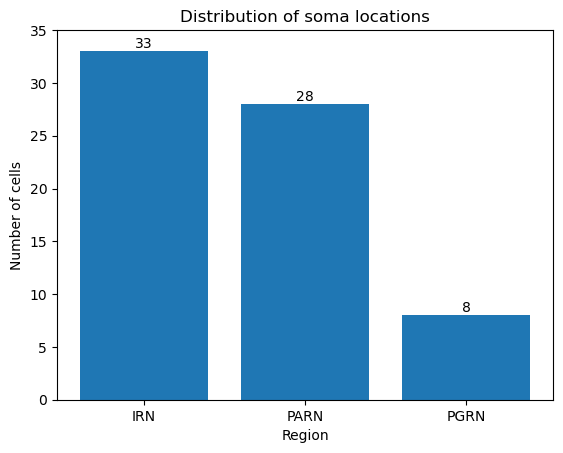

In [ ]:
#this is hardcoded, im leaving as such for now, don't feel like rewriting json functionality for the AA and annotator labeled reconstructions
soma_freq = [33,28,8]
soma_locs = ['IRN', 'PARN', 'PGRN']
#soma_perc = [(x/np.sum(soma_freq))*100 for x in soma_freq]
fig, ax = plt.subplots()
bar_container = ax.bar(soma_locs, soma_freq)
ax.set(ylabel='Number of cells', xlabel='Region', title='Distribution of soma locations', ylim=[0,35])
ax.bar_label(bar_container, fmt='{:,.0f}')

[ 0  5 10 15 20 25 30 35 40 45 50 55 60 65 70 75]
Mean number of target regions per cell: 27.97457627118644


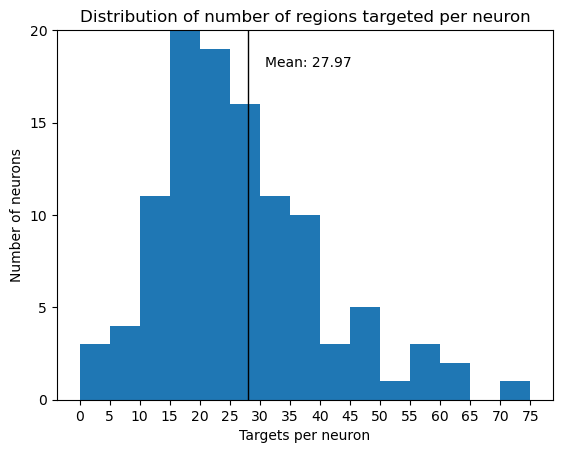

In [81]:
#first gonna do a histo of number of regions targeted
#maybe this should be done on non merged, lets try it quick
true_if_targeted = frequency_ppd > 0 #right now doing it on non merged data think that makes more sense
targets_per_cell = []
for row in true_if_targeted.iterrows():
    sum = 0
    #print(row)
    for info in row:
        for val in info:
            if val is True:
                sum += 1
            else:
                continue
    targets_per_cell.append(sum)
#print(targets_per_cell, len(targets_per_cell))
bins = np.arange(0,80,5)
yrange = np.arange(0,30,5)
print(bins)
target_hist = plt.hist(targets_per_cell, bins=bins)
plt.xticks(bins)
plt.yticks(yrange)
plt.xlabel('Targets per neuron')
plt.ylabel('Number of neurons')
plt.title('Distribution of number of regions targeted per neuron')
plt.axvline(np.mean(targets_per_cell), color='k', linestyle='solid', linewidth=1)
plt.ylim(0, 20)
min_ylim, max_ylim = plt.ylim()
plt.text(np.mean(targets_per_cell)*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(np.mean(targets_per_cell)))
avg_targets = np.mean(targets_per_cell)
print(f'Mean number of target regions per cell: {avg_targets}')

Text(0.5, 1.0, 'Spearman correlation of pontine motif regions')

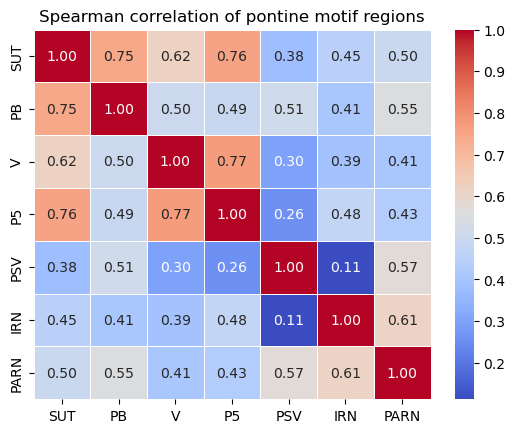

In [82]:
#follow up here is probably some correlation analysis, what regions tend to recieve projections from the same cell 
#(helps investigate that pontine motif that I think I see, are projections to those regions actually correlated?)
#just look at SUT/PB/V/PSV/P5
#use merged_ppd probably? or should i just variance threshold and use without ln scaling
pontine_vals = [merged_ppd.SUT, merged_ppd.PB, merged_ppd.V, merged_ppd.P5, merged_ppd.PSV, merged_ppd.IRN, merged_ppd.PARN]
#print(type(pontine_vals))
pontine_df = pd.DataFrame(pontine_vals).T
#testing different correlation methods, think spearman is the best? my data isn't necessarily linear?
# methods = ['pearson', 'spearman', 'kendall']
# fig, axes = plt.subplots(1,3,figsize=(15,4))
# for i, method in enumerate(methods):
#     pontine_corr = pontine_df.corr(method=method)
#     sns.heatmap(ax=axes[i], data=pontine_corr, annot=True, fmt='.2f')
#     axes[i].set_title(f'correlation with method: {method}')
pontine_corr = pontine_df.corr(method='spearman')
sns.heatmap(pontine_corr, fmt='.2f', linewidths=0.5, annot=True, cmap='coolwarm')
plt.title('Spearman correlation of pontine motif regions')

In [17]:
V_list = []
P5_list = []
SUT_list = []
PB_list = []

V_values = merged_ppd['V']
P5_values = merged_ppd['P5']
SUT_values = merged_ppd['SUT']
PB_values = merged_ppd['PB']

V_nozero = V_values[V_values!=0].index.tolist()
P5_nozero = P5_values[P5_values!=0].index.tolist()
SUT_nozero = SUT_values[SUT_values!=0].index.tolist()
PB_nozero = PB_values[PB_values!=0].index.tolist()

print(f' V: {len(V_nozero)}{V_nozero}')
print(f' P5: {len(P5_nozero)}{P5_nozero}')
print(f' SUT: {len(SUT_nozero)}{SUT_nozero}')
print(f' PB: {len(PB_nozero)}{PB_nozero}')



 V: 28['AA0434', 'AA0503', 'AA0947', 'AA1196', 'AA1329', 'AA1332', 'AA1348', 'AA1460', 'AA1514', 'AA1518', 'AA1521', 'AA1535', 'N004-674185-DS', 'N031-674185-FMR', 'N032-674185-IB', 'N034-674191-IB', 'N039-674185-IB', 'N039-715345-DS', 'N053-653159-YP', 'N059-653159-AK', 'N066-665081-YP', 'N067-685221-HS', 'N086-686955-HD', 'N090-686955-LS', 'N112-708369-JN', 'N126-708369-HD', 'N128-708369-HS', 'N129-708369-YP']
 P5: 34['AA0434', 'AA0503', 'AA0947', 'AA1196', 'AA1313', 'AA1332', 'AA1348', 'AA1349', 'AA1460', 'AA1514', 'AA1518', 'AA1521', 'AA1535', 'N004-674185-DS', 'N031-674185-FMR', 'N032-674185-IB', 'N034-674191-IB', 'N036-674191-SP', 'N039-674185-IB', 'N039-715345-DS', 'N042-674185-SP', 'N046-658735-AR', 'N053-653159-YP', 'N058-653159-PC', 'N059-653159-AK', 'N059-665081-KA', 'N064-665081-JN', 'N066-665081-YP', 'N086-686955-HD', 'N090-686955-LS', 'N112-708369-JN', 'N126-708369-HD', 'N128-708369-HS', 'N129-708369-YP']
 SUT: 35['AA0503', 'AA0947', 'AA1196', 'AA1313', 'AA1329', 'AA1331'

Text(0.5, 1.0, 'Cross-correlation of regions that recieved more than 1% of total dataset projections')

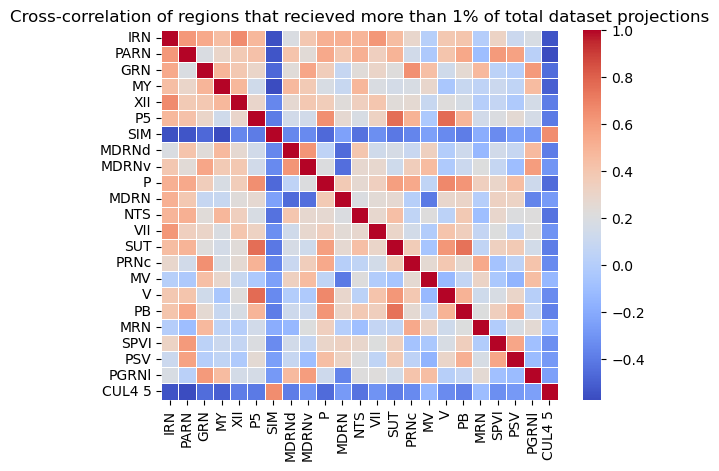

In [18]:
#i think new idea is do this correlation but on the top most targeted regions from before and see if anything sticks out
#mossy fibers now separated out
#theres probably a better way to sort this? honestly not sure what is usually done here, i should just ask some people
to_corr = pd.DataFrame()
for region in x:
    to_corr = pd.concat([to_corr, merged_ppd[region]], axis=1)

to_corr = to_corr
correlated = to_corr.corr(method='spearman')
sns.heatmap(correlated, linewidths=0.5, cmap='coolwarm')
plt.title(r'Cross-correlation of regions that recieved more than 1% of total dataset projections')


c:\Users\samkr\.local\share\mamba\envs\reconstructions\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


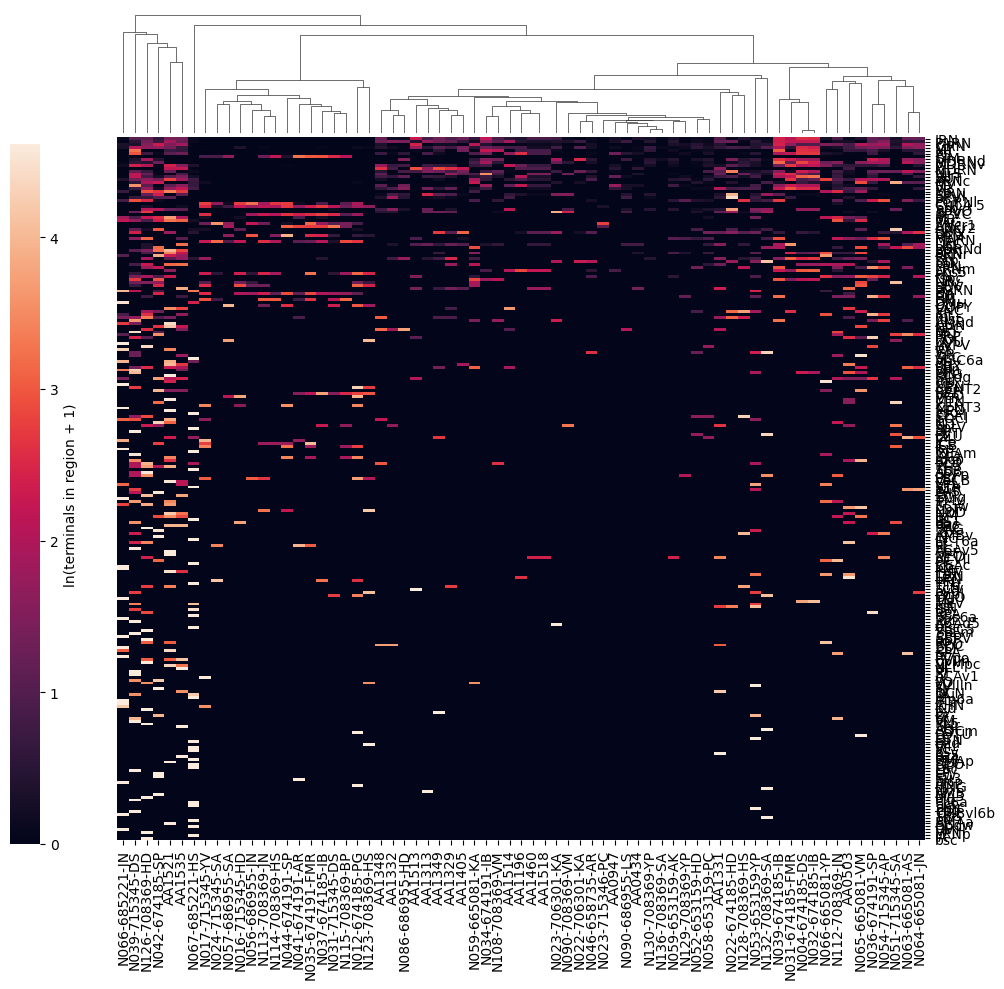

In [19]:
#want to sort my clustermap by highest average proj per region, avg of each region, this is done on merged regions so i can see how to do this, next is to do it on the lateralized dataset
selector = VarianceThreshold(threshold=0.0).set_output(transform='pandas')
merged_frequency = selector.fit_transform(merged_frequency)
#print(merged_frequency.head())
merged_transposed = merged_frequency.T
merged_transposed['mean'] = merged_transposed.mean(axis=1)
sorted_avg = merged_transposed.sort_values('mean', ascending=False)
sorted_avg = sorted_avg.drop(columns=['mean'])
#print(sorted_avg.head())
# avgd_merged = merged_frequency.apply(np.mean, axis=0)
# sorted_avg = avgd_merged.sort_values(ascending=False).head()
for i, row in sorted_avg.iterrows():
    sum = np.sum(row)
    sorted_avg.loc[i] = row.map(lambda x: np.log(((x/sum)*100)+1))
cluster_and_plot(sorted_avg)

In [20]:
#want to remove 'fiber tracts', 'wholebrain', 'Other'
#idk what to do with the larger region annotations (MY, P, etc)
regions = list(merged_frequency.keys())
print(regions)
print(merged_frequency.head())

['LRN', 'CLI', 'LP', 'SOCl', 'VPMpc', 'DEC', 'Su3', 'icp', 'MDRNv', 'MPO', 'V', 'CUN', 'AIp6a', 'CU', 'PAL', 'll', 'APN', 'NPC', 'IF', 'EW', 'Acs5', 'PC5', 'IMD', 'COPY', 'fx', 'DCN', 'sctv', 'arb', 'RPA', 'SUV', 'SCiw', 'VII', 'NR', 'DR', 'TRN', 'P5', 'PCG', 'c', 'SCig', 'GPi', 'FN', 'py', 'ICd', 'VTA', 'CENT2', 'LSc', 'PFL', 'x', 'PPY', 'MARN', 'FOTU', 'MTN', 'INC', 'bic', 'pyd', 'LAV', 'Pa4', 'SCdg', 'CB', 'LING', 'ECU', 'ADP', 'CP', 'SPVC', 'RPO', 'PPN', 'CUL4 5', 'XII', 'SPFm', 'fr', 'LRNm', 'STR', 'VNC', 'VIIn', 'IRN', 'PSV', 'tspc', 'PRP', 'PoT', 'V3', 'AMBd', 'y', 'PVT', 'ICB', 'LC', 'STN', 'mcp', 'NOD', 'EPd', 'DMX', 'SCO', 'chpl', 'rust', 'FL', 'PB', 'MPN', 'RM', 'EPI', 'CS', 'SI', 'LAT', 'V4r', 'das', 'MB', 'ANcr2', 'MD', 'VISC5', 'scp', 'uf', 'BMAp', 'CENT3', 'AHN', 'III', 'MY', 'VI', 'KF', 'ACVII', 'amc', 'ANcr1', 'act', 'AMBv', 'ml', 'ORBvl6b', 'vVIIIn', 'SPIV', 'cpd', 'tb', 'GR', 'VCO', 'PGRNd', 'GRN', 'TMv', 'SSs6a', 'AQ', 'MRN', 'PAG', 'pc', 'AVPV', 'SPVO', 'CEAm', 'SO

In [ ]:
# #another good plot would be dist of soma location, how many in IRN/PARN/PGRNd, can pull that info from SNT I think just might have to hardcode it here
# #use brainrender to plot some diagrams of exact soma location
# #this will only be including the ones that we got recently, none of the "AA" ones since I don't have swc's
# #kernel keeps dying here, gonna comment it all out for now and return later this week
# #vedo.settings.default_backend='vtk'
# swc_dir = input('Input directory with SWC files: ') #C:\Reconstructions\registered_MY_IRN_PARN_PGRN\medulla_IRN_PRN_PGRN\modfied_swc
# file_list = os.listdir(swc_dir)
# neurons = []
# timelist= []
# for file in file_list:
#     start = time.perf_counter()
#     filepath = os.path.join(swc_dir, file)
#     parts1 = file.split('.')
#     f = parts1[0]
#     parts2 = f.split("_")
#     file = parts2[1]
#     #print(file)
#     neuron = Neuron(filepath)
#     neurons.append(neuron)
#     end = time.perf_counter()
#     print(f'Loaded {file} as Neuron! Took {end-start} seconds')
#     timelist.append(end-start)

# print(f'Avg time to load file: {np.mean(timelist)}')
# print(f'max time to load file: {np.max(timelist)}')
# print(f'min time to load file: {np.min(timelist)}')
# print(f'Total time to load files: {np.sum(timelist)}')

Loaded N004-674185-DS as Neuron! Took 29.537297300063074 seconds
Loaded N012-674185-PG as Neuron! Took 11.979704600060359 seconds
Loaded N016-715345-HD as Neuron! Took 8.07314969995059 seconds
Loaded N017-715345-YV as Neuron! Took 9.360950600006618 seconds
Loaded N022-674185-HD as Neuron! Took 22.126412900048308 seconds
Loaded N022-706301-KA as Neuron! Took 3.5372302999021485 seconds
Loaded N023-706301-KA as Neuron! Took 7.595913300057873 seconds
Loaded N023-715346-PC as Neuron! Took 3.9302873000269756 seconds
Loaded N024-715345-SA as Neuron! Took 8.420850499998778 seconds
Loaded N031-674185-FMR as Neuron! Took 24.707146300002933 seconds
Loaded N031-715345-DS as Neuron! Took 9.5520079000853 seconds
Loaded N032-674185-IB as Neuron! Took 27.852569399983622 seconds
Loaded N034-674191-IB as Neuron! Took 13.249309099977836 seconds
Loaded N035-674191-FMR as Neuron! Took 13.926991400076076 seconds
Loaded N036-674191-SP as Neuron! Took 14.189412000006996 seconds
Loaded N037-674185-IB as Neuron

: 

In [ ]:
#setting lists so I can get ontology information for each region
#think this is unneeded now
# regions = frequency_ppd.keys()
# regions_target_contra = []
# regions_target_ipsi = []
# for region in regions:
#     expi = 'Ipsilateral'
#     expc = 'Contralateral'
#     if expi in region:
#         #reg = region.replace(expi+' ', '')
#         regions_target_ipsi.append(region)
#     if expc in region:
#         #reg2 = region.replace(expc+' ', '')
#         regions_target_contra.append(region)
# regions_target_ipsi.remove('Ipsilateral Other') #'other' and 'wholebrain are gone already? guess I removed them earlier in my code but tbh im not sure where (maybe in place modified at some point bc jupyter)
# regions_target_contra.remove('Contralateral Other')
# regions_target_ipsi.remove('Ipsilateral wholebrain')
# #regions_target_contra.remove('wholebrain')
#print(regions_target_ipsi)



In [ ]:

#okay ideas, do this stuff but on the lateralized dataset so i can get parent ont level, then sort by that then avg strength
#although if i want to eventually do it on the lateralized dataset, this is a beginning, maybe i should sort these then concatenate, then append this to the end of the lateralized dataset 
#to get a column that is the parent region of each child region
#also don't think this is needed anymore
# for i, region in enumerate(regions_target_ipsi):
#     if region == 'Ipsilateral CUL4 5':
#         regions_target_ipsi[i] = 'Ipsilateral CUL4, 5'
# for i, region in enumerate(regions_target_contra):
#     if region == 'Contralateral CUL4 5':
#         regions_target_contra[i] = 'Contralateral CUL4, 5'
# #print(regions_target)
# parent_regions_ipsi = []
# parent_regions_contra = []
# for val in regions_target_contra:
#     val1 = val.replace('Contralateral ', '')
#     parent_i = ccf_v3_10um.structures[val1]['structure_id_path'][-2]
#     parent_regions_contra.append((val, parent_i))
# #print(parent_regions)
# for val in regions_target_ipsi:
#     val2 = val.replace('Ipsilateral ', '')
#     parent_c = ccf_v3_10um.structures[val2]['structure_id_path'][-2]
#     parent_regions_ipsi.append((val, parent_c))
#print(parent_regions)

In [29]:
if 'fiber tracts' in parent_regions_ipsi:
    print('fiber in ipsi parent list')
if 'Ipsilateral fiber' in parent_regions_ipsi:
    print('Ipsilateral fiber in parent ipsi list')
else:
    print('fiber not in ipsi list')
if 'fiber' in parent_regions_contra:
    print('fiber in contra parent list')
if 'Contralateral fiber' in parent_regions_contra:
    print('Contralateral fiber in parent ipsi list')
else:
    print('fiber not in contra list')
    

fiber not in ipsi list
fiber not in contra list


In [ ]:
#get each region with parent ontology level (might have to do this manually since some regions don't have the tag I want)
#doing this manually earlier although it may be a lil tedious well see
#don't think any of this is needed anymore
# tandp_contra = list(zip(regions_target_contra, parent_regions_contra))
# #sorting just gets it so all regions that have the same parent region are grouped together
# sorted_contra = sorted(tandp_contra, key=lambda item: item[1])
# #print(sorted_contra)
# tandp_ipsi = list(zip(regions_target_ipsi, parent_regions_ipsi))
# sorted_ipsi = sorted(tandp_ipsi, key=lambda item: item[1])
# #print(sorted_ipsi)
# ip_then_cont = sorted_ipsi + sorted_contra
# #print(ip_then_cont)
# i_to_c_correct_regions = []
# for info in ip_then_cont:
#     region, parent = info
#     if 'CUL4, 5' in region:
#         parts = region.split(' ')
#         parts[1] = parts[1]+' '+parts[2]
#     else:
#         parts = region.split(' ')
#     parent_path = ccf_v3_10um.structures[parts[1]]["structure_id_path"]
#     if len(parent_path) <= 4:
#         i_to_c_correct_regions.append((region, ccf_v3_10um.structures[parent_path[-1]]['acronym']))
#     else:
#         i_to_c_correct_regions.append((region, ccf_v3_10um.structures[parent_path[4]]['acronym']))
# sorted_ic = sorted(i_to_c_correct_regions, key=lambda item: item[1])
# row_labels = [info[1] for info in sorted_ic]
# print(row_labels)

KeyError: 'fiber'

In [ ]:
print(i_to_c_correct_regions)

[('ICe', 'MBsen'), ('ICd', 'MBsen'), ('ICc', 'MBsen'), ('CB', 'CB'), ('ACAv1', 'CTXpl'), ('PF', 'TH'), ('PIL', 'TH'), ('V4', 'V4'), ('c', 'c'), ('V3', 'V3'), ('VL', 'VL'), ('chpl', 'chpl'), ('AIp6a', 'CTXpl'), ('AMBd', 'MY'), ('AMBv', 'MY'), ('PO', 'TH'), ('Eth', 'TH'), ('LP', 'TH'), ('DMH', 'HY'), ('AVPV', 'HY'), ('MPO', 'HY'), ('PVpo', 'HY'), ('SBPV', 'HY'), ('ADP', 'HY'), ('NR', 'MY'), ('PRP', 'MY'), ('PVi', 'HY'), ('DR', 'MBsta'), ('CLI', 'MBsta'), ('IF', 'MBsta'), ('sptV', 'sV'), ('LRNm', 'MY'), ('LRNp', 'MY'), ('LSv', 'STR'), ('LSc', 'STR'), ('IA', 'STR'), ('ZI', 'HY'), ('STN', 'HY'), ('TU', 'HY'), ('SCdg', 'MBmot'), ('SCiw', 'MBmot'), ('SCdw', 'MBmot'), ('SCig', 'MBmot'), ('BMAa', 'CTXsp'), ('BMAp', 'CTXsp'), ('MRN', 'MBmot'), ('PAG', 'MBmot'), ('CUN', 'MBmot'), ('RN', 'MBmot'), ('VTA', 'MBmot'), ('SNr', 'MBmot'), ('uf', 'scp'), ('sctv', 'scp'), ('SCO', 'MBsen'), ('MEV', 'MBsen'), ('SAG', 'MBsen'), ('MB', 'MB'), ('PPN', 'MBsta'), ('IRN', 'MY'), ('MDRN', 'MY'), ('VII', 'MY'), ('L

In [50]:
#test for laterality stuff in json_to_freq
pos = np.sign(1)
nums = [-1, -54, -3, 4, 6, 2]
ipsi = []
contra = []
for num in nums:
    if np.sign(num) == pos:
        ipsi.append(num)
    if np.sign(num) != pos:
        contra.append(num)

print(ipsi, contra)

[4, 6, 2] [-1, -54, -3]


In [ ]:
for i, region in enumerate(row_labels)

SyntaxError: expected ':' (2360213003.py, line 1)

In [ ]:
unique = []
for region in row_labels:
    if region not in unique:
        unique.append(region)
    else:
        continue
print(len(unique))
print(unique)

53
['AQ', 'CB', 'CTXpl', 'CTXsp', 'DN', 'FN', 'HEM', 'HY', 'IP', 'MB', 'MBmot', 'MBsen', 'MBsta', 'MY', 'P', 'PAL', 'STR', 'TH', 'V3', 'V4', 'V4r', 'VERM', 'VIIn', 'VL', 'VeCB', 'act', 'amc', 'arb', 'bsc', 'c', 'cVIIIn', 'cett', 'chpl', 'cpd', 'csc', 'fa', 'fiber tracts', 'fxs', 'gVIIn', 'icp', 'mcp', 'mfbse', 'mlf', 'nst', 'pc', 'py', 'pyd', 'rust', 'sV', 'scp', 'ts', 'tspc', 'vVIIIn']


In [44]:
ccf_v3_10um.structures['XII']['structure_id_path']

[997, 8, 343, 1065, 354, 370, 773]

In [49]:
ccf_v3_10um.structures[773]


{
    'acronym': 'XII',
    'id': 773,
    'name': 'Hypoglossal nucleus',
    'structure_id_path': [997, 8, 343, 1065, 354, 370, 773],
    'rgb_triplet': [255, 179, 217],
    'mesh_filename': WindowsPath('C:/Users/samkr/.brainglobe/allen_mouse_10um_v1.2/meshes/773.obj'),
    'mesh': <meshio mesh object>
  Number of points: 399
  Number of cells:
    triangle: 790
  Point data: obj:vn
  Cell data: obj:group_ids
}

In [ ]:
#testing what color labels should be
iris = sns.load_dataset("iris")
species = iris.pop("species")
lut = dict(zip(species.unique(), "rbg"))
print(lut)
row_colors = species.map(lut)
print(row_colors)
unique = []
for color in row_colors:
    if color not in unique:
        unique.append(color)
    else:
        continue
print(len(unique))

{'setosa': 'r', 'versicolor': 'b', 'virginica': 'g'}
0      r
1      r
2      r
3      r
4      r
      ..
145    g
146    g
147    g
148    g
149    g
Name: species, Length: 150, dtype: object
3


In [118]:
frequency_tocluster.head()

AA0434    AA0503    AA0947    AA1196    AA1313    AA1329  \
Ipsilateral IRN   3.547343  1.193574  2.574230  2.261112  3.156406  2.762990   
Ipsilateral MDRN  2.332370  1.193574  1.511903  1.417066  2.077344  2.414952   
Ipsilateral VII   1.918972  0.000000  0.000000  0.000000  0.000000  1.854067   
Ipsilateral LIN   1.501490  0.000000  0.000000  0.000000  0.608672  0.000000   
Ipsilateral PARN  1.201645  1.102436  2.023619  1.842532  3.626796  2.502104   

                    AA1331    AA1332    AA1348    AA1349  ...  N113-708369-JN  \
Ipsilateral IRN   3.378270  0.432133  2.345066  2.989808  ...        0.000000   
Ipsilateral MDRN  1.934416  1.565232  2.172820  2.574961  ...        0.000000   
Ipsilateral VII   1.640937  0.000000  0.000000  0.000000  ...        0.000000   
Ipsilateral LIN   0.891998  0.239230  0.000000  0.191422  ...        0.000000   
Ipsilateral PARN  3.036874  3.693598  1.679562  2.034126  ...        0.335333   

                  N114-708369-HS  N115-708369-BP  N123-708369-HS  \
Ipsilateral IRN              0.0             0.0             0.0   
Ipsilateral MDRN             0.0             0.0             0.0   
Ipsilateral VII              0.0             0.0             0.0   
Ipsilateral LIN              0.0             0.0             0.0   
Ipsilateral PARN             0.0             0.0             0.0   

                  N126-708369-HD  N128-708369-HS  N129-708369-YP  \
Ipsilateral IRN         2.426496        2.744903         1.53393   
Ipsilateral MDRN        0.000000        0.000000         0.00000   
Ipsilateral VII         0.845777        2.114031         0.00000   
Ipsilateral LIN         0.000000        0.395709         0.00000   
Ipsilateral PARN        1.851967        0.678477         0.00000   

                  N130-708369-YP  N132-708369-SA  N136-708369-SA  
Ipsilateral IRN         2.185460        0.777705             0.0  
Ipsilateral MDRN        0.000000        0.000000             0.0  
Ipsilateral VII         0.000000        0.462624             0.0  
Ipsilateral LIN         0.000000        0.000000             0.0  
Ipsilateral PARN        2.650272        0.137201             0.0  

[5 rows x 69 columns]

In [ ]:
#this is now broken because some regions don't have ontology annotation
annot = pd.read_csv('region_list_for_annotation.csv')
#frequency_tocluster['Mean'] = np.mean(frequency_tocluster, axis=1)
ont_lut = {
    'CTX': "#12ff0a",  
    'HY': "#c70000",   
    'TH': "#ff7676",   
    'MB': "#ff01ea",   
    'CB': "#fffb02",   
    'P-sen': "#ffa048",
    'P-mot': "#fc802e",
    'P-sat': "#ffba7a",
    'P': "#fd6500",    
    'MY-mot': "#f574ce",
    'MY-sen': "#ff98e0",
    'MY-sat': "#faafe3",
    'MY': "#f84ac4",
    'Other':  "#ada798fd",
    'CNU': "#00fff2fc"  
}
index_df = pd.DataFrame({'FullRegion': frequency_tocluster.index})
index_df = index_df.merge(annot, left_on='FullRegion', right_on='Region', how='left')
index_df[['Laterality', 'Region']] = index_df['Region'].str.extract(r'^(Ipsilateral|Contralateral) (.+)$')
index_df['MeanProjection'] = frequency_tocluster.mean(axis=1).values

laterality_order = {'Ipsilateral': 0, 'Contralateral': 1}
index_df['LateralityOrder'] = index_df['Laterality'].map(laterality_order)

ontology_order = {'CTX':0, 'CNU':1, 'HY':2, 'TH':3, 'MB':4, 'CB':5, 'P':6, 'P-sen':7, 'P-mot':8,
                 'P-sat':9, 'MY':10, 'MY-mot':11, 'MY-sen':12, 'MY-sat':13, 'Other':14}  # adjust for your ontology levels
index_df['OntologyOrder'] = index_df['Ontology'].map(ontology_order)
sorted_index = index_df.sort_values(by=['LateralityOrder', 'OntologyOrder', 'MeanProjection'], ascending=[True, True, False])
#sorted_index['color'] = ont_lut[]
freq_sorted = frequency_tocluster.reindex(sorted_index['FullRegion'])
#print(freq_sorted)
row_colors = [ont_lut[cat] for cat in sorted_index['Ontology']]
print(row_colors)

KeyError: nan

In [22]:
#checking min to make sure the bounds I set don't accidentally set some actual data to 0 in the colormap
min_nozero = []
for col in freq_sorted:
    min_nozero.append(freq_sorted[freq_sorted[col] != 0][col].min())

print(np.min(min_nozero))

0.024161600582392674


In [23]:
vals = freq_sorted.values
nonzero = vals[vals != 0]
vmin = nonzero.min() if nonzero.size>0 else 0
vmax = nonzero.max() if nonzero.size>0 else 1
base_cmap = plt.cm.bwr
bounds = [0, 0.00001] + list(np.linspace(vmin, vmax, 256))
zero_color = (np.float64(0),np.float64(0),np.float64(0),np.float64(1))
colors = [zero_color] + [base_cmap(i) for i in range(base_cmap.N)]
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(bounds, cmap.N, clip=True)
#freq_sorted = np.ma.masked_where(freq_sorted == 0, freq_sorted)

In [24]:
print(colors)

[(np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(1.0)), (np.float64(0.0), np.float64(0.0), np.float64(1.0), np.float64(1.0)), (np.float64(0.00784313725490196), np.float64(0.00784313725490196), np.float64(1.0), np.float64(1.0)), (np.float64(0.01568627450980392), np.float64(0.01568627450980392), np.float64(1.0), np.float64(1.0)), (np.float64(0.023529411764705882), np.float64(0.023529411764705882), np.float64(1.0), np.float64(1.0)), (np.float64(0.03137254901960784), np.float64(0.03137254901960784), np.float64(1.0), np.float64(1.0)), (np.float64(0.0392156862745098), np.float64(0.0392156862745098), np.float64(1.0), np.float64(1.0)), (np.float64(0.047058823529411764), np.float64(0.047058823529411764), np.float64(1.0), np.float64(1.0)), (np.float64(0.054901960784313725), np.float64(0.054901960784313725), np.float64(1.0), np.float64(1.0)), (np.float64(0.06274509803921569), np.float64(0.06274509803921569), np.float64(1.0), np.float64(1.0)), (np.float64(0.07058823529411765), np.fl

c:\Users\samkr\.local\share\mamba\envs\reconstructions\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


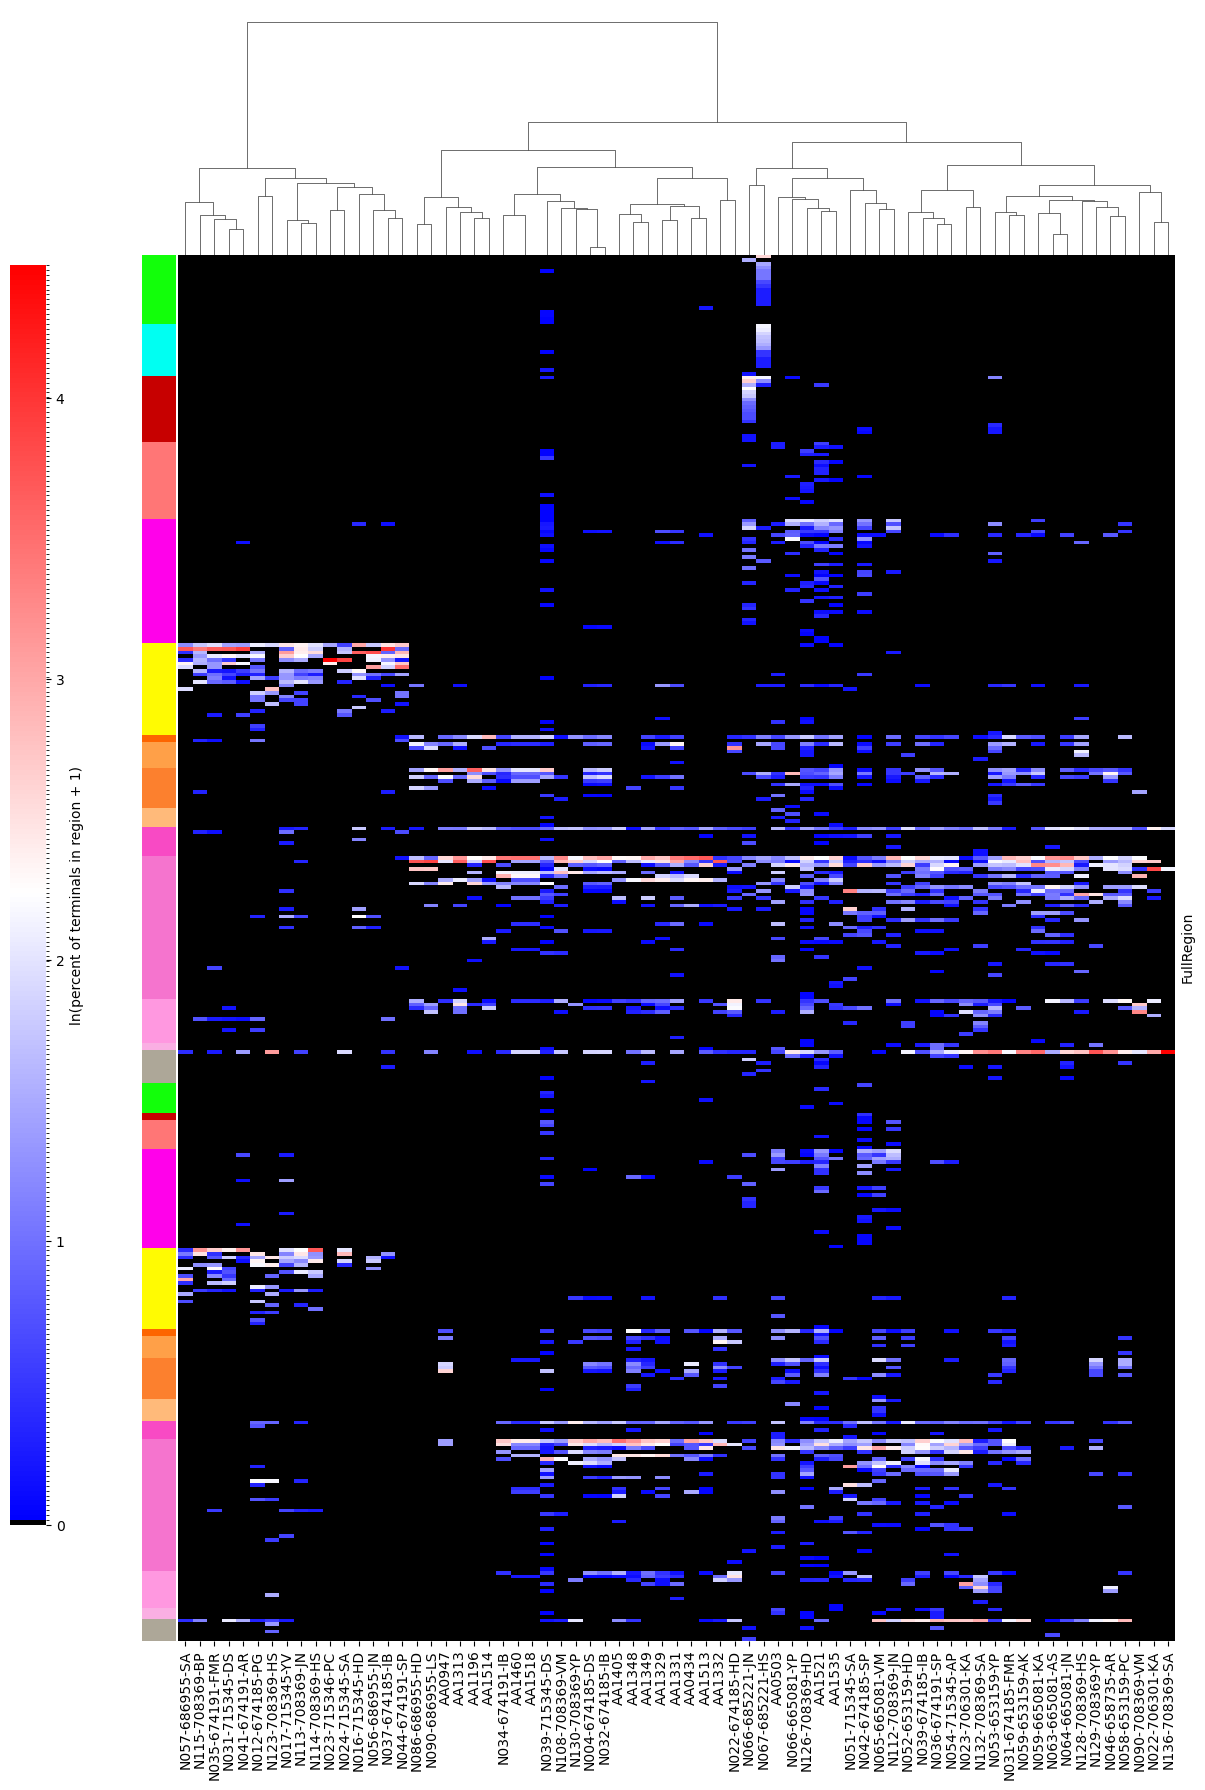

In [25]:
g = sns.clustermap(freq_sorted,
        method='ward',
        metric='euclidean',
        cmap = cmap,
        norm=norm,
        row_cluster=False,
        col_cluster=True,
        row_colors=row_colors,
        dendrogram_ratio=(.1, .15),
        cbar_pos=(0, .15, .03, .7),
        cbar_kws={'label': 'ln(percent of terminals in region + 1)'},
        yticklabels=False,
        xticklabels=True,
        figsize=(12, 18),         # wider figure for right axis
)
cbar_ax = g.cax
cbar_ax.yaxis.set_major_formatter(mticker.FormatStrFormatter(r'%d'))
cbar_ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
g.figure.canvas.draw()
g.savefig('recons_clustermap.png')


In [35]:
cells = frequency_tocluster.keys()
for cell in cells:
    print(cell)

AA0434
AA0503
AA0947
AA1196
AA1313
AA1329
AA1331
AA1332
AA1348
AA1349
AA1405
AA1460
AA1513
AA1514
AA1518
AA1521
AA1535
N004-674185-DS
N012-674185-PG
N016-715345-HD
N017-715345-YV
N022-674185-HD
N022-706301-KA
N023-706301-KA
N023-715346-PC
N024-715345-SA
N031-674185-FMR
N031-715345-DS
N032-674185-IB
N034-674191-IB
N035-674191-FMR
N036-674191-SP
N037-674185-IB
N039-674185-IB
N039-715345-DS
N041-674191-AR
N042-674185-SP
N044-674191-SP
N046-658735-AR
N051-715345-SA
N052-653159-HD
N053-653159-YP
N054-715345-AP
N056-686955-JN
N057-686955-SA
N058-653159-PC
N059-653159-AK
N059-665081-KA
N063-665081-AS
N064-665081-JN
N065-665081-VM
N066-665081-YP
N066-685221-JN
N067-685221-HS
N086-686955-HD
N090-686955-LS
N090-708369-VM
N108-708369-VM
N112-708369-JN
N113-708369-JN
N114-708369-HS
N115-708369-BP
N123-708369-HS
N126-708369-HD
N128-708369-HS
N129-708369-YP
N130-708369-YP
N132-708369-SA
N136-708369-SA


In [82]:
frequency_tocluster.head()

AA0434    AA0503    AA0947    AA1196    AA1313    AA1329  \
Ipsilateral IRN   3.547343  1.193574  2.574230  2.261112  3.156406  2.762990   
Ipsilateral MDRN  2.332370  1.193574  1.511903  1.417066  2.077344  2.414952   
Ipsilateral VII   1.918972  0.000000  0.000000  0.000000  0.000000  1.854067   
Ipsilateral LIN   1.501490  0.000000  0.000000  0.000000  0.608672  0.000000   
Ipsilateral PARN  1.201645  1.102436  2.023619  1.842532  3.626796  2.502104   

                    AA1331    AA1332    AA1348    AA1349  ...  N113-708369-JN  \
Ipsilateral IRN   3.378270  0.432133  2.345066  2.989808  ...        0.000000   
Ipsilateral MDRN  1.934416  1.565232  2.172820  2.574961  ...        0.000000   
Ipsilateral VII   1.640937  0.000000  0.000000  0.000000  ...        0.000000   
Ipsilateral LIN   0.891998  0.239230  0.000000  0.191422  ...        0.000000   
Ipsilateral PARN  3.036874  3.693598  1.679562  2.034126  ...        0.335333   

                  N114-708369-HS  N115-708369-BP  N123-708369-HS  \
Ipsilateral IRN              0.0             0.0             0.0   
Ipsilateral MDRN             0.0             0.0             0.0   
Ipsilateral VII              0.0             0.0             0.0   
Ipsilateral LIN              0.0             0.0             0.0   
Ipsilateral PARN             0.0             0.0             0.0   

                  N126-708369-HD  N128-708369-HS  N129-708369-YP  \
Ipsilateral IRN         2.426496        2.744903         1.53393   
Ipsilateral MDRN        0.000000        0.000000         0.00000   
Ipsilateral VII         0.845777        2.114031         0.00000   
Ipsilateral LIN         0.000000        0.395709         0.00000   
Ipsilateral PARN        1.851967        0.678477         0.00000   

                  N130-708369-YP  N132-708369-SA  N136-708369-SA  
Ipsilateral IRN         2.185460        0.777705             0.0  
Ipsilateral MDRN        0.000000        0.000000             0.0  
Ipsilateral VII         0.000000        0.462624             0.0  
Ipsilateral LIN         0.000000        0.000000             0.0  
Ipsilateral PARN        2.650272        0.137201             0.0  

[5 rows x 69 columns]

In [26]:
freq_trans = frequency_tocluster.T
xii_and_v = freq_trans.loc[(freq_trans['Ipsilateral V'] > 0) & (freq_trans['Ipsilateral XII'] > 0) 
                                    & (freq_trans['Contralateral V'] > 0) & (freq_trans['Contralateral XII'] > 0)]
xii = freq_trans.loc[(freq_trans['Ipsilateral XII'] > 0) & (freq_trans['Contralateral XII'] > 0)]
v = freq_trans.loc[(freq_trans['Ipsilateral V'] > 0) & (freq_trans['Contralateral V'] > 0)]

C:\Users\samkr\AppData\Local\Temp\ipykernel_48636\3308638257.py:7: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(freq_ad, key_added='clusters')


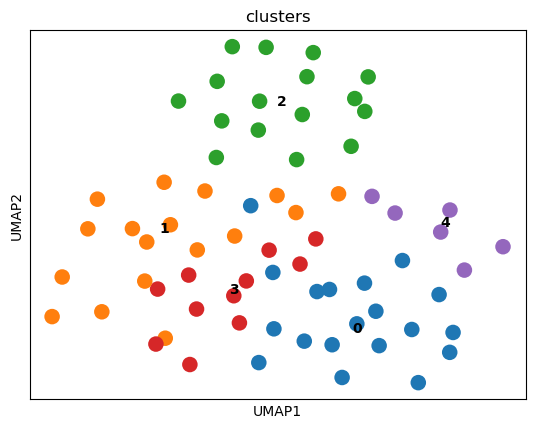

In [27]:
#okay umap time, think i can just do this on sorted_freq? actually lets do it on freq_tocluster
freq_t = frequency_tocluster.T
freq_ad = sc.AnnData(freq_t)
sc.pp.scale(freq_ad)
sc.pp.pca(freq_ad)
sc.pp.neighbors(freq_ad)
sc.tl.leiden(freq_ad, key_added='clusters')
sc.tl.umap(freq_ad)
# freq_ad.obs['clusters'] = freq_ad.obs['clusters'].astype('category')
# categories = {'0': 'non-GRN bilateral', 
#               '1': 'GRN spinal cord',
#               '2': 'CB projecting', 
#               '3': 'no'}
# freq_ad.obs['clusters'] = freq_ad.obs['clusters'].cat.rename_categories()
#freq_ad.obs.loc['AA0503'][0] = '4'
sc.pl.umap(freq_ad, color='clusters', legend_loc='on data', size=500)

In [28]:
freq_t

Ipsilateral IRN  Ipsilateral MDRN  Ipsilateral VII  \
AA0434                 1.528746          2.495627         1.964056   
AA0503                -0.341823          1.027788        -0.536738   
AA0947                 0.755401          1.438095        -0.536738   
AA1196                 0.506562          1.315855        -0.536738   
AA1313                 1.218064          2.166915        -0.536738   
...                         ...               ...              ...   
N128-708369-HS         0.891037         -0.510658         2.218255   
N129-708369-YP        -0.071338         -0.510658        -0.536738   
N130-708369-YP         0.446441         -0.510658        -0.536738   
N132-708369-SA        -0.672320         -0.510658         0.066150   
N136-708369-SA        -1.290372         -0.510658        -0.536738   

                Ipsilateral LIN  Ipsilateral PARN  Ipsilateral MY  \
AA0434                 4.395412          0.004951       -0.162937   
AA0503                -0.398810         -0.079212        1.052021   
AA0947                -0.398810          0.702272        0.318539   
AA1196                -0.398810          0.548646        1.270245   
AA1313                 1.544665          2.062324        0.287220   
...                         ...               ...             ...   
N128-708369-HS         0.864679         -0.438878        1.593172   
N129-708369-YP        -0.398810         -1.014462        0.936535   
N130-708369-YP        -0.398810          1.233892        1.210167   
N132-708369-SA        -0.398810         -0.898068        1.159513   
N136-708369-SA        -0.398810         -1.014462        1.458847   

                Ipsilateral GRN  Ipsilateral PGRN  Ipsilateral V  \
AA0434                -0.050194         -0.266453      -0.566014   
AA0503                 1.032659          5.700220       0.111951   
AA0947                -0.813598         -0.266453       3.027872   
AA1196                -0.544483         -0.266453       3.319998   
AA1313                -0.813598         -0.266453      -0.566014   
...                         ...               ...            ...   
N128-708369-HS        -0.598549         -0.266453      -0.241567   
N129-708369-YP         1.277465         -0.266453      -0.566014   
N130-708369-YP         0.017448         -0.266453      -0.566014   
N132-708369-SA         0.543666         -0.266453      -0.566014   
N136-708369-SA        -0.813598         -0.266453      -0.566014   

                Ipsilateral XII  ...  Ipsilateral PoT  Ipsilateral VPMpc  \
AA0434                -0.568231  ...        -0.120386          -0.120386   
AA0503                 1.901191  ...        -0.120386          -0.120386   
AA0947                -0.568231  ...        -0.120386          -0.120386   
AA1196                 1.589706  ...        -0.120386          -0.120386   
AA1313                -0.568231  ...        -0.120386          -0.120386   
...                         ...  ...              ...                ...   
N128-708369-HS        -0.568231  ...        -0.120386          -0.120386   
N129-708369-YP        -0.568231  ...        -0.120386          -0.120386   
N130-708369-YP         2.748544  ...        -0.120386          -0.120386   
N132-708369-SA        -0.568231  ...        -0.120386          -0.120386   
N136-708369-SA        -0.568231  ...        -0.120386          -0.120386   

                Ipsilateral SNr  Ipsilateral LRNp  Ipsilateral PIL  \
AA0434                -0.120386         -0.120386        -0.120386   
AA0503                -0.120386         -0.120386        -0.120386   
AA0947                -0.120386         -0.120386        -0.120386   
AA1196                -0.120386         -0.120386        -0.120386   
AA1313                -0.120386         -0.120386        -0.120386   
...                         ...               ...              ...   
N128-708369-HS        -0.120386         -0.120386        -0.120386   
N129-708369-YP        -0.120386         -0.120386       

In [29]:
type(freq_ad.obs.loc['AA0503'][0])

C:\Users\samkr\AppData\Local\Temp\ipykernel_48636\3663731463.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  type(freq_ad.obs.loc['AA0503'][0])


<class 'str'>

In [30]:
umap_id = freq_ad.obs
clusters = [group for _, group in umap_id.groupby('clusters')]
for i in range(0,5):
    print(clusters[i])

                clusters
AA0434                 0
AA0503                 0
AA0947                 0
AA1196                 0
AA1329                 0
AA1331                 0
AA1332                 0
AA1348                 0
AA1349                 0
AA1405                 0
AA1460                 0
AA1513                 0
AA1518                 0
AA1521                 0
AA1535                 0
N004-674185-DS         0
N031-674185-FMR        0
N032-674185-IB         0
N034-674191-IB         0
               clusters
N022-706301-KA        1
N046-658735-AR        1
N051-715345-SA        1
N052-653159-HD        1
N053-653159-YP        1
N058-653159-PC        1
N059-653159-AK        1
N059-665081-KA        1
N063-665081-AS        1
N064-665081-JN        1
N066-665081-YP        1
N066-685221-JN        1
N067-685221-HS        1
N128-708369-HS        1
N129-708369-YP        1
N132-708369-SA        1
N136-708369-SA        1
                clusters
N012-674185-PG         2
N016-715345-HD    

C:\Users\samkr\AppData\Local\Temp\ipykernel_48636\2403427813.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  clusters = [group for _, group in umap_id.groupby('clusters')]


In [31]:
morph_features = pd.read_csv(r'SNT-measurements-csv.csv', index_col = 'Neuron')
to_drop = ['Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17']
morph_features = morph_features.drop(columns=to_drop)
print(morph_features)


                      Width  No. of tips  cable length        depth  \
Neuron                                                                
AA0434          3035.996419          106   25157.37217  3249.878926   
AA0503          6593.506214          370  123082.29060  4061.864719   
AA0947          3422.846308          215   45610.49486  3747.445547   
AA1196          3556.066250          658   75638.50370  1876.904974   
AA1313          3248.743510          746   82674.38965  1380.304405   
...                     ...          ...           ...          ...   
N128-708369-HS  5373.633100          422   59851.74547  2704.904500   
N129-708369-YP  4927.197900          122   31031.92604  3009.134300   
N130-708369-YP  3024.214600          178   32403.93861  3778.695100   
N132-708369-SA  4854.834300          717   89244.62342  4671.970100   
N136-708369-SA  3485.635600           88   17204.96943  1426.465300   

                      heigh  primary branches  inner branches  branches  \
N

c:\Users\samkr\.local\share\mamba\envs\reconstructions\Lib\site-packages\legacy_api_wrap\__init__.py:82: UserWarning: X converted to numpy array with dtype float64
  return fn(*args_all, **kw)


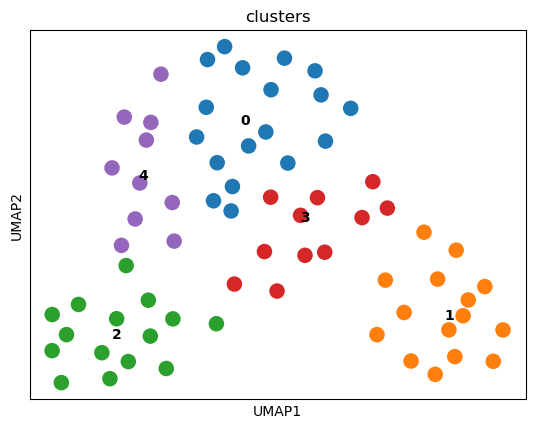

In [32]:
morph_a = sc.AnnData(morph_features)
sc.pp.scale(morph_a)
sc.pp.pca(morph_a)
sc.pp.neighbors(morph_a)
sc.tl.leiden(morph_a, key_added='clusters')
sc.tl.umap(morph_a)
sc.pl.umap(morph_a, color='clusters', legend_loc='on data', size=500)

In [33]:
uids = morph_a.obs
clusters2 = [group for _, group in uids.groupby('clusters')]
for i in range(0,5):
    print(clusters2[i])

               clusters
Neuron                 
AA0434                0
AA0947                0
AA1196                0
AA1313                0
AA1329                0
AA1331                0
AA1332                0
AA1348                0
AA1405                0
AA1460                0
AA1514                0
N023-706301-KA        0
N044-674191-SP        0
N051-715345-SA        0
N086-686955-HD        0
N090-686955-LS        0
N090-708369-VM        0
N136-708369-SA        0
                clusters
Neuron                  
N012-674185-PG         1
N016-715345-HD         1
N017-715345-YV         1
N023-715346-PC         1
N024-715345-SA         1
N031-715345-DS         1
N035-674191-FMR        1
N037-674185-IB         1
N041-674191-AR         1
N056-686955-JN         1
N057-686955-SA         1
N113-708369-JN         1
N114-708369-HS         1
N115-708369-BP         1
N123-708369-HS         1
                clusters
Neuron                  
AA1513                 2
AA1521              

C:\Users\samkr\AppData\Local\Temp\ipykernel_48636\3683614951.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  clusters2 = [group for _, group in uids.groupby('clusters')]


In [ ]:
#jus tdone to manually annotate region ontology, not needed anymore
# df_annotation = pd.DataFrame({'Region': sorted_tocluster.index, 'Ontology': ['']*len(sorted_tocluster)})
# df_annotation.to_csv('region_list_for_annotation.csv', index=False)

# print("Region list saved to 'region_list_for_annotation.csv' (with empty ontology column).")

Region list saved to 'region_list_for_annotation.csv' (with empty ontology column).


In [ ]:
#now unneeded, was done to examine cells that move clusters, will come back later
# df_annot = pd.DataFrame({'Neuron': freq_sorted.columns, 'UMAP cluster': ['']*len(freq_sorted.columns), 'Hierarchical cluster': ['']*len(freq_sorted.columns)})
# df_annot.to_csv('neuron_cluster_info.csv', index=False)

c:\Users\samkr\.local\share\mamba\envs\reconstructions\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


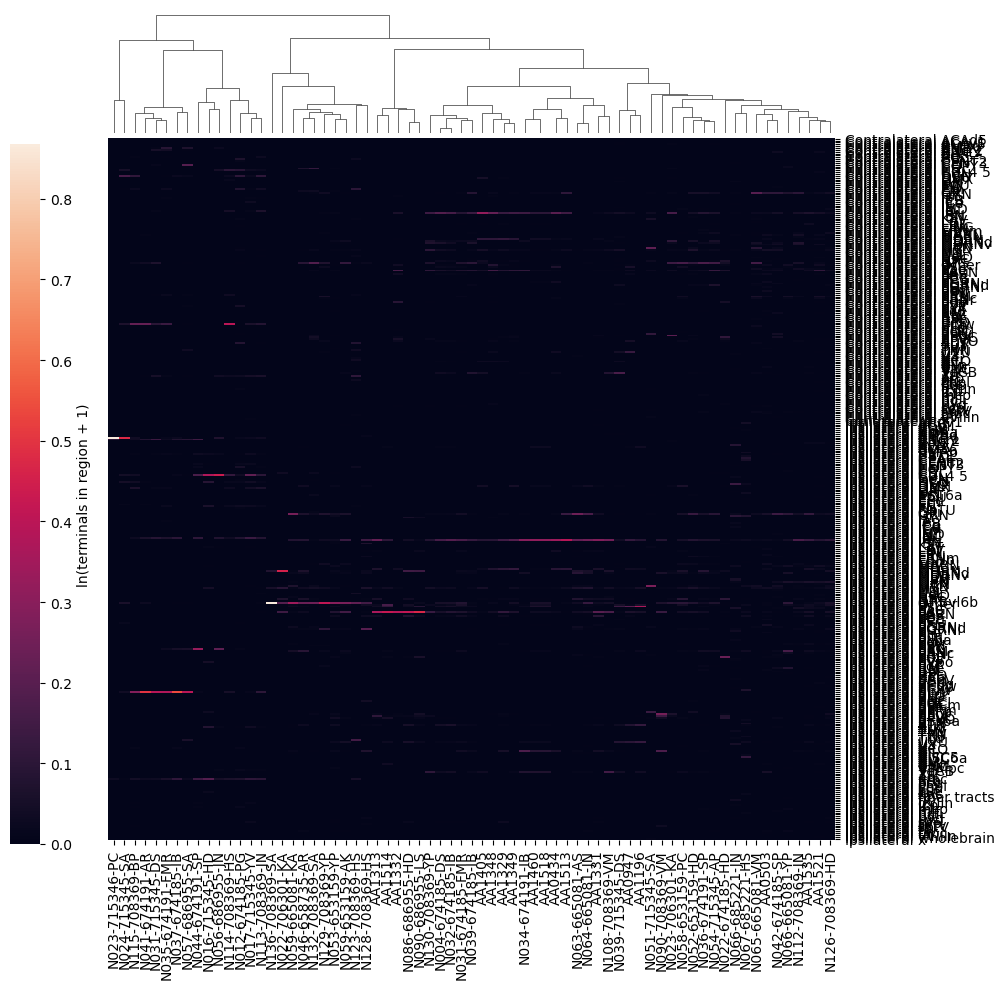

In [64]:
#hierarchical clustering on freq dataset
cmap_freq = cluster_and_plot(frequency_tocluster)
#cmap.plot()
#plt.show()

In [ ]:
#tbh unnecessary work just wanted to work my python skills but its not worth the time rn
selector = VarianceThreshold(threshold=0.0).set_output(transform='pandas')
freq_hasvar = selector.fit_transform(frequency_data)
#print(freq_hasvar.head())
thresh = 5
mask = (freq_hasvar > 0) & (freq_hasvar <= thresh)
#print(mask.head())
rois = []
for i, row in mask.iterrows():
    rowroi = []
    for col, val in row.items():
        if val is True:
            rowroi.append((col, val))
        rois.append(rowroi)
#print(rois)
#idek what i was doing here anymore lmao

[[('Ipsilateral MDRNd', True), ('Ipsilateral NTS', True), ('Ipsilateral PRNr', True), ('Ipsilateral MEV', True), ('Ipsilateral PCG', True), ('Ipsilateral MV', True), ('Contralateral scp', True), ('Contralateral PPN', True), ('Contralateral SPVI', True), ('Contralateral DMX', True)], [('Ipsilateral MDRNd', True), ('Ipsilateral NTS', True), ('Ipsilateral PRNr', True), ('Ipsilateral MEV', True), ('Ipsilateral PCG', True), ('Ipsilateral MV', True), ('Contralateral scp', True), ('Contralateral PPN', True), ('Contralateral SPVI', True), ('Contralateral DMX', True)], [('Ipsilateral MDRNd', True), ('Ipsilateral NTS', True), ('Ipsilateral PRNr', True), ('Ipsilateral MEV', True), ('Ipsilateral PCG', True), ('Ipsilateral MV', True), ('Contralateral scp', True), ('Contralateral PPN', True), ('Contralateral SPVI', True), ('Contralateral DMX', True)], [('Ipsilateral MDRNd', True), ('Ipsilateral NTS', True), ('Ipsilateral PRNr', True), ('Ipsilateral MEV', True), ('Ipsilateral PCG', True), ('Ipsilater

c:\Users\samkr\.local\share\mamba\envs\reconstructions\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


TypeError: Image data of dtype object cannot be converted to float

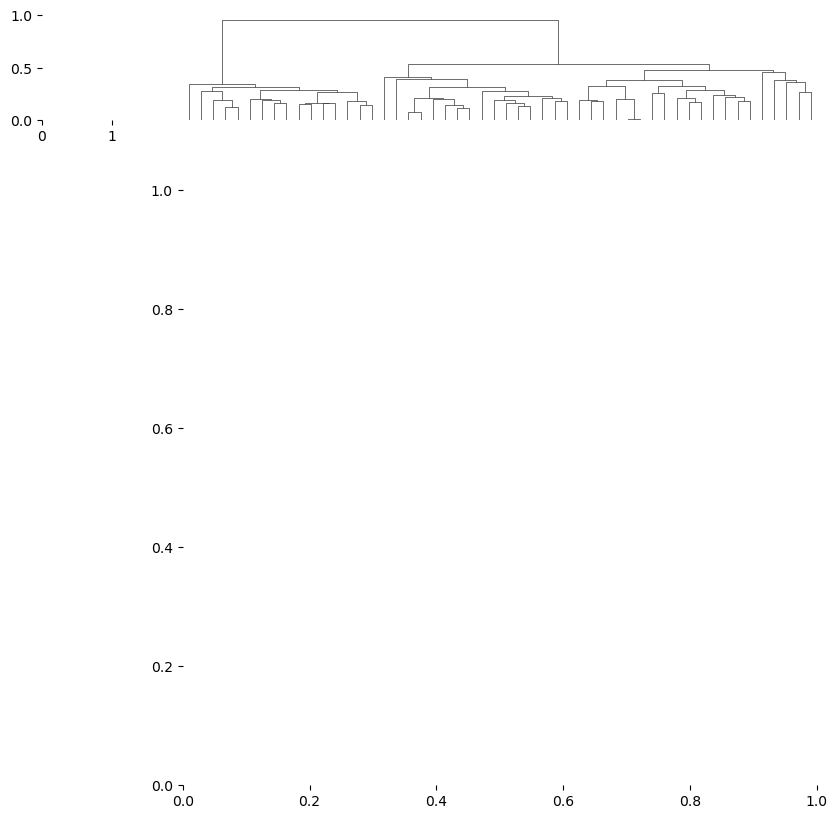

In [ ]:
#hierarchical clustering on the length dataset
#this is not working correctly atm for whatever reason, ill leave it be for now i think
#just don't worry about this for a bit lmao
#length_tocluster = length_tocluster.sort_index(axis=0)
#cmap_length = cluster_and_plot(length_tocluster)
sns.clustermap(length_tocluster, 
                method='ward', 
                metric='euclidean', 
                row_cluster=False,
                dendrogram_ratio=(.1, .15),
                cbar_pos=(0, .15, .03, .7),
                cbar_kws={'label': 'ln(terminals in region + 1)'},
                yticklabels=True,
                xticklabels=True)

In [ ]:
help(cmap)

Help on ClusterGrid in module seaborn.matrix object:

class ClusterGrid(seaborn.axisgrid.Grid)
 |  ClusterGrid(data, pivot_kws=None, z_score=None, standard_scale=None, figsize=None, row_colors=None, col_colors=None, mask=None, dendrogram_ratio=None, colors_ratio=None, cbar_pos=None)
 |  
 |  Method resolution order:
 |      ClusterGrid
 |      seaborn.axisgrid.Grid
 |      seaborn.axisgrid._BaseGrid
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, data, pivot_kws=None, z_score=None, standard_scale=None, figsize=None, row_colors=None, col_colors=None, mask=None, dendrogram_ratio=None, colors_ratio=None, cbar_pos=None)
 |      Grid object for organizing clustered heatmap input on to axes
 |  
 |  dim_ratios(self, colors, dendrogram_ratio, colors_ratio)
 |      Get the proportions of the figure taken up by each axes.
 |  
 |  format_data(self, data, pivot_kws, z_score=None, standard_scale=None)
 |      Extract variables from data or use directly.
 |  
 |  plo